# Hydrogeodesy: Monitoring surface waters from space
### Exercise 1: From measured ranges to water level & pre-processed inland altimetry products

Daniel Scherer, DGFI-TUM  
Wintersemester 2022/23

**Contents**
1. Height estimation and retracker comparison
2. Water level time series
3. Waveform analysis (optional)

**Study Area: Lake Stamford (Texas, USA)**  
![AOI](aoi.Png)  
*Figure 1: Lake Stamford*  

| Area Variation | Water Level Variation |
| --- | --- |
| 3 – 18 km² | 426 – 431 m |

First import some required libraries:

In [1]:
import pathlib # Just simplifies the handling of pathes
import netCDF4 as nc # required to open netcdf files
import matplotlib.pyplot as plt # standard plotting library

### 1. Height estimation and retracker comparison

Satellite altimetry data is commonly provided by **pass** and **cyle** numbers.  
The pass number identifies a segment (usually pole to pole or equator intersection to equator intersection) of the repeating groundtrack.  
The cycle number identifies the repetition of the groundtrack.
  
The example water body "Lake Stamford" intersects with pass number 230 of the Jason-2 mission.  
Please choose a cycle number between 50 and 300 when loading the data below:

In [2]:
cycle_nr = ... # Choose a number between 50 and 300 
mva_data_root = pathlib.Path('data/lake_stamford/mva')
dset = nc.Dataset(mva_data_root / f'jason2_{cycle_nr:03d}_0230.nc')

Now we load all variables:

In [8]:
lon = dset["glon"][:] # longitude
lat = dset["glat"][:] # latitude
jday = dset["jday"][:] # julian day of measurement
geoh = dset["geoh"][:] # geoid
hsat = dset["hsat"][:] # satellite height
wtrop = dset["wtrop"][:] # wet troposhpere component
dtrop = dset["dtrop"][:] # dry troposphere component
ionos = dset["ionos"][:] # ionosphere
etide = dset["etide"][:] # earth tide
ptide = dset["ptide"][:] # pole tide
uralt = dset["uralt"][:] # uncoreected range
ralt_ocean = dset["ralt_ocean"][:] # range from ocean retracker
ralt_ice = dset["ralt_ice"][:] # range from ice retracker
ralt_dahiti = dset["ralt_imth_dahiti"][:] # range from dahiti (improved thresholds) retracker
dset.close()

Calculate the water level using range from the ice, ocean, and dahiti retracker:

In [61]:
heights_ice = ...
heights_ocean = ...
heights_dahiti = ...

Now we can plot the calculated water levels along the latitude component of the orbit groundtrack:

In [ ]:
fig, ax = plt.subplots()
ax.plot(lat,heights_ice,marker='.',color="r",label='Ice')
ax.plot(lat,heights_ocean,marker='.',color="k",label='Ocean')
ax.plot(lat,heights_dahiti,marker='.',color="b",label='DAHITI')
plt.legend(title='Retracker')
plt.xlabel("Latitude [˚]")
plt.ylabel("Water Level [m]")
plt.title(f"Retracked Water Level for Lake Stamford. Jason-2 Pass 230, Cycle {cycle_nr:03d}")
plt.show()

Think about the following questions:  
- Which geophysical correction is most significant?  
- What effect do you recognize looking at the plotted heights along the altimeter track?  
- How do the results differ by retracker?  
- What would be the best method to calculate a suitable single water level for this overflight (cycle)?  

### 2. Water Level Time Series

Based on Figure 1 and your plotted heights by latitude, chose suitable outlier criteria for latitude and height so we can rejectcorrupted measurements in the following.

In [ ]:
min_lat = ...
max_lat = ...
min_height = ...
max_height = ...

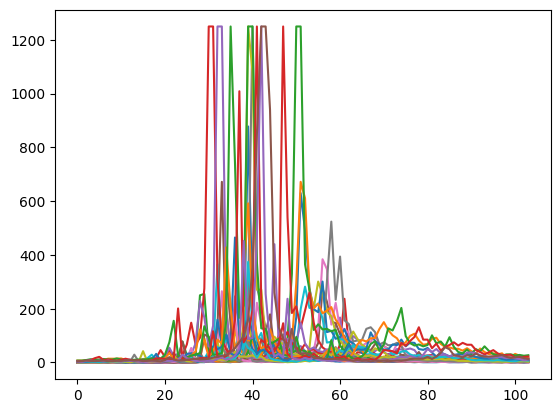

In [11]:
dset = nc.Dataset(mva_data_root / f'jason2_050_0230.nc')
for waveform in dset['waveform_dahiti']:
    plt.plot(waveform)
plt.show()
dset.close()